# Stock Market Forecasting Using Stacked LSTM

## This Week: Train LSTMs Faster with Google Colab!

Hopefully you've looked through the Brightspace file before engaging in this Jupyter Notebook. Please take a moment to learn about LSTMs before adding this to Colab. Below are some quick reminders:

**1. Head to Colab:**  Open a web browser and go to https://research.google.com/colaboratory/.

**2. Upload Your Notebook:** There are two ways to upload your notebook:

- **Drag and Drop:** Click the "Upload" button in the top left corner of the Colab interface. Drag and drop your downloaded notebook file (.ipynb) from your computer into the upload window.

- **File Menu:** Click on "File" -> "Upload notebook" and select your notebook file from your computer's folders.
    
**3. Wait for Upload:**  Colab will upload your notebook.  This might take a few seconds depending on the size of your file.

**4. Run the Cells:**  Once uploaded, your notebook will appear in Colab.  You can now run the code cells one by one (using the "Run" button or keyboard shortcuts - Shift+Enter) just like you would in your local Jupyter Notebook environment.

**Tip:** Make sure you have a stable internet connection for a smooth Colab experience.

By following these steps, you'll be able to leverage Google Colab's power and train your LSTMs much faster, allowing you to focus on understanding and experimenting with these powerful models!

## Functional Code

Read the comments of each of the cells to make sure you can identify each of the following steps:

1. Download data from Yahoo Finance as a .csv file
2. Import the .csv file as a dataframe and use it to train our LSTM across multiple *"Epochs"*
3. Verify that our training was accurate using proper metrics (root mean square deviation, RMS)
4. Use our nicely trained model to predict the price of the stock during the following *"n_days"*

In [13]:
### Import Libraries here
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import math
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [19]:
# DOWNLOAD DATA FROM THE STOCK YOU WANT TO PREDICT
# Just provide the ticker and the start and end date
# This cell will pull the historical values of the stock of your choice from Yahoo Finance
# then download it as a .csv file
import yfinance as yf
from datetime import datetime

# Define ticker symbol
ticker = "WBD"

# Define start and end date
start_date = datetime(2018, 9, 1)
#end_date = datetime.today()
end_date = datetime(2024,3,1)

# Download data using yfinance
ticker_data = yf.download(ticker)  # Download for ticker by default

# Select data for the desired period (optional)
if start_date is not None and end_date is not None:
    ticker_data = ticker_data.loc[start_date:end_date]  # Filter data using pandas indexing

# Save data to CSV file
filename = f"{ticker}.csv"
ticker_data.to_csv(filename)

print(f"{ticker} data from {start_date} to {end_date} saved to {filename}")

[*********************100%%**********************]  1 of 1 completed

WBD data from 2018-09-01 00:00:00 to 2024-03-01 00:00:00 saved to WBD.csv


         Date       Open       High        Low      Close  Adj Close   Volume
0  2018-09-04  27.600000  27.889999  27.160000  27.469999  27.469999  3176100
1  2018-09-05  27.540001  27.930000  27.410000  27.459999  27.459999  5589100
2  2018-09-06  27.629999  28.040001  27.389999  27.620001  27.620001  3231500
3  2018-09-07  27.520000  28.240000  27.320000  27.950001  27.950001  3111800
4  2018-09-10  28.049999  28.350000  27.700001  28.299999  28.299999  2586500


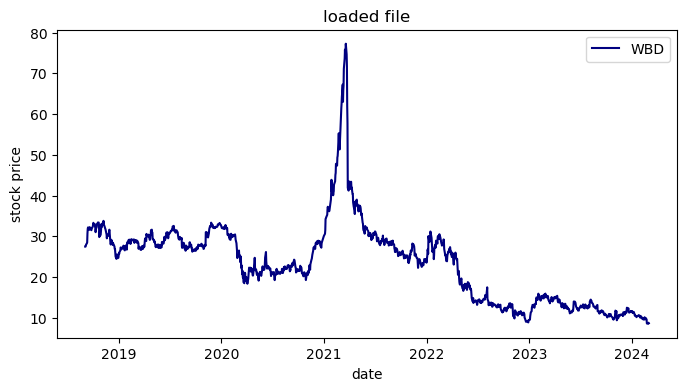

Epoch 1/20
20/20 [==============================] - 3s 48ms/step - loss: 0.0122 - val_loss: 0.0063
Epoch 2/20
20/20 [==============================] - 1s 29ms/step - loss: 0.0027 - val_loss: 2.1038e-04
Epoch 3/20
20/20 [==============================] - 1s 29ms/step - loss: 0.0021 - val_loss: 4.6648e-04
Epoch 4/20
20/20 [==============================] - 1s 29ms/step - loss: 0.0019 - val_loss: 2.4603e-04
Epoch 5/20
20/20 [==============================] - 1s 30ms/step - loss: 0.0016 - val_loss: 9.3031e-04
Epoch 6/20
20/20 [==============================] - 1s 30ms/step - loss: 0.0014 - val_loss: 1.0828e-05
Epoch 7/20
20/20 [==============================] - 1s 31ms/step - loss: 0.0014 - val_loss: 1.1312e-05
Epoch 8/20
20/20 [==============================] - 1s 31ms/step - loss: 0.0013 - val_loss: 6.1932e-05
Epoch 9/20
20/20 [==============================] - 1s 31ms/step - loss: 0.0012 - val_loss: 1.2886e-05
Epoch 10/20
20/20 [==============================] - 1s 31ms/step - loss: 0.0

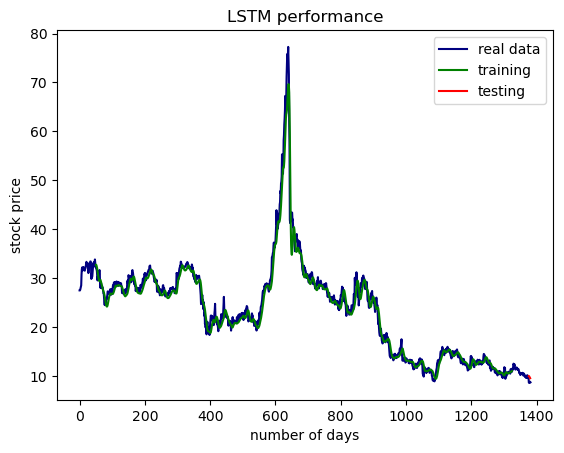

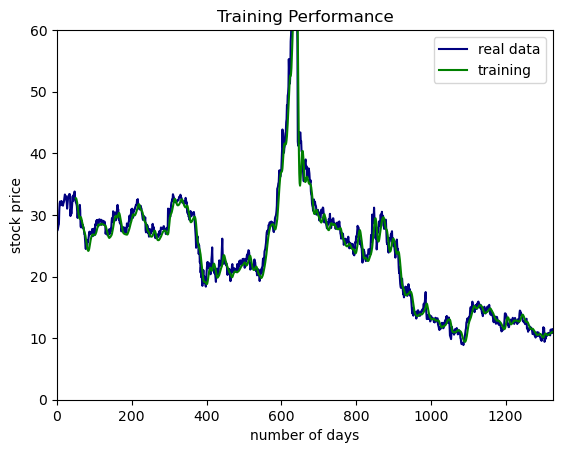

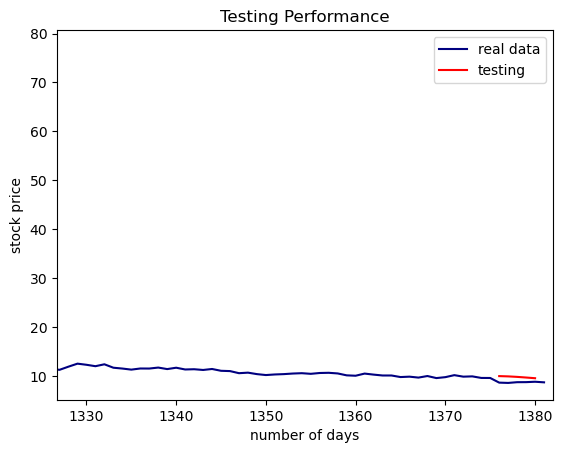

In [20]:
# ITERATIVE LSTM PREDICTION OF ALL TICKERS INSERTED
# Download .csv files with historical prices from Yahoo Finance
files = [ticker] # List of the tickers to load, add your other tickers here

for file in files:

  # LOADING FILES
  filename = str(file) + ".csv"
  df=pd.read_csv(filename) #create dataframe (df)
  print(df.head(5)) #prints the first lines of the loaded dataframe for us to check
  df_prices=df.reset_index()['Close'] #create list of closing prices
  df_dates=df.reset_index()['Date'] #create list of dates
  df_dates = pd.to_datetime(df_dates,format='%Y-%m-%d') #set date format

  # PLOT the prices of the ticker loaded right now
  plt.figure(figsize=(8,4))
  plt.plot(df_dates, df_prices, color='navy', label=file)
  plt.legend(loc="best")
  plt.title("loaded file")
  plt.xlabel("date")
  plt.ylabel("stock price")
  plt.show()

  # APPLY MinMax SCALER
  # this transforms the prices in values from -1 and 1
  # this homogeneization of the data favors LSTM accuracy
  scaler=MinMaxScaler(feature_range=(0,1)) #create MinMax scaler
  # note that the MinMax scaler can only be applied to ARRAYs
  # note that df_prices is not a list of prices any more but an array
  # of values between of -1 to 1 (proportional to the prices)
  df_prices=scaler.fit_transform(np.array(df_prices).reshape(-1,1))

  # SPLIT list of prices into TRAIN data and TEST data
  split_percentage = 0.96 #splitting 80% for training, 20% for testing
  training_size=int(len(df_prices)*split_percentage) #calculate length of training data
  test_size=len(df_prices)-training_size #calculate length of test data
  train_data=df_prices[0:training_size,:] #create list of training data
  test_data=df_prices[training_size:len(df_prices),:1] #create list of test data

  # CONVERT THE ARRAY OF SCALED VALUES INTO A MATRIX
  # the following function creates dataset matrices with (X, Y) shape
  # X will be the scaled price, Y will be the number of day (from 1 to len(df_prices))
  def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

  # RESHAPE ARRAYS into MATRICES (to be able to pass it into the LSTM model)
  # using the function created above
  look_back = 50 #number of days we want to use to predict the following price
  X_train, y_train = create_dataset(train_data, look_back) #training matrix
  X_test, ytest = create_dataset(test_data, look_back) #testing matrix
  # Reshape input to be [samples, time steps, features], which is required for LSTM
  X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
  if len(test_data) > look_back:
    X_test, ytest = create_dataset(test_data, look_back)
    # Reshape input to be [samples, time steps, features], which is required for LSTM
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
  else:
    print(f"Not enough data to create test sequences. Test data length: {len(test_data)}, Look back: {look_back}")

  ## CREATE THE STACKED LSTM MODEL
  model=Sequential()
  model.add(LSTM(50,return_sequences=True,input_shape=(look_back,1)))
  model.add(LSTM(50,return_sequences=True))
  model.add(LSTM(50))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error',optimizer='adam')

  #TRAIN THE MODEL
  #this step is quite time consuming
  #the completion time is proportional to the number of Epochs
  Epochs = 200
  model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=Epochs,batch_size=64,verbose=1)

  # PREDICT OUR TRAINING AND TEST DATA using the TRAINED LSTM MODEL
  if X_test.size == 0:
    print("X_test is empty. Skipping prediction for this ticker.")
  else:
    # PREDICT OUR TRAINING AND TEST DATA using the TRAINED LSTM MODEL
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

  # Transformback to original form
  train_predict=scaler.inverse_transform(train_predict)
  test_predict=scaler.inverse_transform(test_predict)

  # CHECK RMSE PERFORMANCE METRICS (to evaluate our predictions)
  # Evaluate prediction of TRAINING data
  RMSE_training = math.sqrt(mean_squared_error(y_train,train_predict))
  # Evaluate prediction of TEST data
  RMSE_test = math.sqrt(mean_squared_error(ytest,test_predict))
  # display the performance
  print("The performance of the LSTM of " + file + " is:")
  print("RMSE Training = ", RMSE_training)
  print("RMSE Test = ", RMSE_test)

  # PLOTTING THE SUCCESS OF THE LSTM MODEL
  # First we need to horizontally shift the train and test predictions
  # so that they match the horizontal position of the real prices
  # Shift train predictions for plotting
  trainPredictPlot = np.empty_like(df_prices)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
  # Shift test predictions for plotting
  testPredictPlot = np.empty_like(df_prices)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_prices)-1, :] = test_predict

  # PLOT LSTM training and testing performance
  plt.plot(scaler.inverse_transform(df_prices), color='navy', label="real data")
  plt.plot(trainPredictPlot, color='green', label="training")
  plt.plot(testPredictPlot, color='red', label="testing")
  plt.legend(loc="best")
  plt.title("LSTM performance")
  plt.xlabel("number of days")
  plt.ylabel("stock price")
  plt.show()

  # PLOT LSTM only training performance
  plt.plot(scaler.inverse_transform(df_prices), color='navy', label="real data")
  plt.plot(trainPredictPlot, color='green', label="training")
  plt.xlim(0,len(df_prices)*split_percentage)
  plt.ylim(0,60)
  plt.legend(loc="best")
  plt.title("Training Performance")
  plt.xlabel("number of days")
  plt.ylabel("stock price")
  plt.show()

  # PLOT LSTM only testing performance
  plt.plot(scaler.inverse_transform(df_prices), color='navy', label="real data")
  plt.plot(testPredictPlot, color='red', label="testing")
  plt.xlim(len(df_prices)*split_percentage, len(df_prices))
  plt.legend(loc="best")
  plt.title("Testing Performance")
  plt.xlabel("number of days")
  plt.ylabel("stock price")
  plt.show()

/var/folders/n3/txrlfsh951bgh92kl_ryy0nw0000gn/T/ipykernel_11974/2492711743.py:52: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(days_look_back, real_prices_look_back, '-ok', color='navy', label="real data")
/var/folders/n3/txrlfsh951bgh92kl_ryy0nw0000gn/T/ipykernel_11974/2492711743.py:53: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ok" (-> color='k'). The keyword argument will take precedence.
  plt.plot(days_predicted, predicted_prices_corrected, '-ok', color='purple', label="prediction")


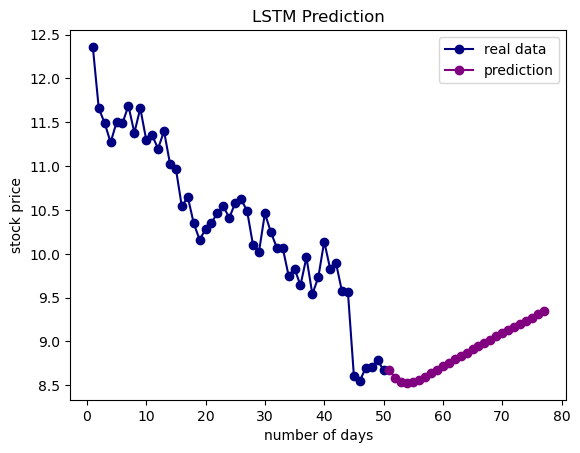

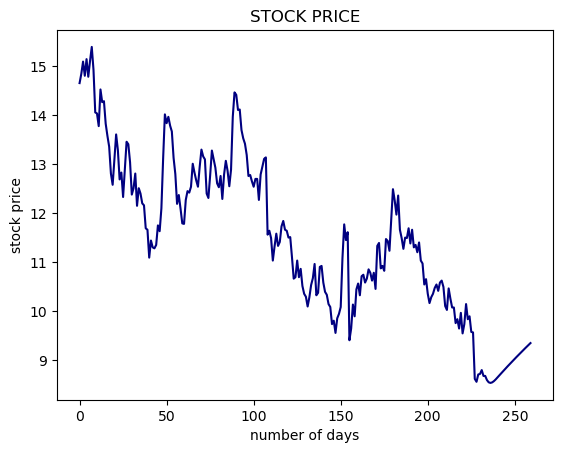

In [21]:
  # PREDICT THE NEXT n_days
  # create input list with the real prices during the look_back period
  # and reshape it from -1 to +1
  x_input=test_data[len(test_data)-look_back:].reshape(1,-1)
  # transform, temporarily, the input array into a list
  temp_input=list(x_input)
  temp_input=temp_input[0].tolist()

  n_days = 27 #number of days to predict
  lstm_output = [] #array to store predictions
  n_steps = look_back # number of steps needed to predict the next price
  i=0

  while(i < n_days):

      if(len(temp_input)>n_steps):
          x_input=np.array(temp_input[1:])
          x_input=x_input.reshape(1,-1)
          x_input = x_input.reshape((1, n_steps, 1))
          yhat = model.predict(x_input, verbose=0)
          #add prediction value to the list of inputs for the prediction
          temp_input.extend(yhat[0].tolist())
          temp_input=temp_input[1:]
          lstm_output.extend(yhat.tolist())
          i=i+1
      else:
          x_input = x_input.reshape((1, n_steps,1))
          yhat = model.predict(x_input, verbose=0)
          temp_input.extend(yhat[0].tolist())
          lstm_output.extend(yhat.tolist())
          i=i+1

# PLOT PREDICTIONS FOLLOWING THE GRAPH
# this graph will have real data (length=look_back) on the left
# and predicted_prices on the right (length=n_days)
# we calculate the days first
days_look_back=np.arange(1, look_back+1)
days_predicted=np.arange(look_back+1, look_back+1+n_days)
# now we calculate the prices
real_prices_look_back = scaler.inverse_transform(df_prices[len(df_prices)-look_back:])
predicted_prices = scaler.inverse_transform(lstm_output)

# VERTICAL OFFSET OF THE PREDICTIONS
# since the first prediction point is too low (LSTM error)
# I will offset this point vertically so that it overlaps the previous point
# this offset is the last price of real_prices_look_back minus
# the first price of predicted_prices
vertical_offset = real_prices_look_back[-1] - predicted_prices [0]
predicted_prices_corrected = predicted_prices + vertical_offset

# PLOT PREDICTIONS, right after the real values
plt.plot(days_look_back, real_prices_look_back, '-ok', color='navy', label="real data")
plt.plot(days_predicted, predicted_prices_corrected, '-ok', color='purple', label="prediction")
#plt.xlim(95,105)
plt.legend(loc="best")
plt.title("LSTM Prediction")
plt.xlabel("number of days")
plt.ylabel("stock price")
plt.show()

# You could also add the predicted data right at the end of your real values
df_finalPrices=scaler.inverse_transform(df_prices) #create list of real prices
df_finalPrices=df_finalPrices.tolist() #convert array into list
df_finalPrices.extend(predicted_prices_corrected) #add predicted prices at the end

# Plot all data (real + prediction) last year
#plt.plot(scaler.inverse_transform(df_finalPrices[len(df_finalPrices)-260:]), color='navy')
plt.plot(df_finalPrices[len(df_finalPrices)-260:], color='navy')

#plt.xlim(247,255)
plt.title("STOCK PRICE")
plt.xlabel("number of days")
plt.ylabel("stock price")
plt.show()

# EXPORT real values + prediction
name_file = "lstm_results_" + str(file) + ".csv"
df_exported = pd.DataFrame(df_finalPrices)
df_exported.to_csv(name_file, sep=';', index=False)

## Final thoughts

We’ve seen the advantage of LSTMs in the example of predicting stock prices. Be careful about making generalizations to other stocks, because, unlike other stationary time series, stock market data is less-to-none seasonal and more chaotic.

For well-established big tech companies with proven business models and strong management, historical data tends to be more consistent. This consistency, along with the predictable impact of new product releases, makes their stock prices less volatile. As a result, these stocks are generally easier for LSTM models to predict compared to those with higher volatility.

In [23]:
# CODE TO TRACK FINGERS WITH MEDIAPIPE
import cv2 as cv
import mediapipe as mp
import cv2 as cv
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import numpy as np
import os
import cv2 as cv
from matplotlib import pyplot as plt
import time
import ipywidgets as widgets
from IPython.display import display
from telemetrix import telemetrix
import time
import cv2 as cv
import numpy as np
import os
from matplotlib import pyplot as plt
import time
from telemetrix import telemetrix
import sys
import numpy as np
import os
import cv2 as cv
from matplotlib import pyplot as plt
import pickle


RGB_LED_1_PIN = 6
RGB_LED_2_PIN = 3
RGB_LED_3_PIN = 5




board = telemetrix.Telemetrix()



board.set_pin_mode_digital_output(RGB_LED_1_PIN)
board.set_pin_mode_digital_output(RGB_LED_2_PIN)
board.set_pin_mode_digital_output(RGB_LED_3_PIN)



filename1 = "/Users/scottliu/Desktop/lstm_results_AAPL.csv"
filename2 = "/Users/scottliu/Desktop/lstm_results_GOOGL.csv"
filename3 = "/Users/scottliu/Desktop/lstm_results_WBD.csv"



df1 = pd.read_csv(filename1)
df2 = pd.read_csv(filename2)
df3 = pd.read_csv(filename3)


first_value1 = df1.iloc[0, 0]
last_value1 = df1.iloc[-1, 0]
first_value2 = df2.iloc[0, 0]
last_value2 = df2.iloc[-1, 0]
first_value3 = df3.iloc[0, 0]
last_value3 = df3.iloc[-1, 0]

# Compare and set the LED state
if last_value1 < first_value1:
    # Turn off the LED
    board.digital_write(RGB_LED_1_PIN, 0)
else:
    # Turn on the LED
    board.digital_write(RGB_LED_1_PIN, 1)

    
if last_value2 < first_value2:
    # Turn off the LED
    board.digital_write(RGB_LED_2_PIN, 0)
else:
    # Turn on the LED
    board.digital_write(RGB_LED_2_PIN, 1)



if last_value3 < first_value3:
    # Turn off the LED
    board.digital_write(RGB_LED_3_PIN, 0)
else:
    # Turn on the LED
    board.digital_write(RGB_LED_3_PIN, 1)



Telemetrix:  Version 1.39

Copyright (c) 2021 Alan Yorinks All Rights Reserved.

Opening all potential serial ports...
	/dev/cu.usbmodem1201

Waiting 4 seconds(arduino_wait) for Arduino devices to reset...
Valid Arduino ID Found.
Arduino compatible device found and connected to /dev/cu.usbmodem1201
Waiting for Arduino to reset
Reset Complete

Retrieving Telemetrix4Arduino firmware ID...
Telemetrix4Arduino firmware version: 5.3.3
